[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/integrations/kumo/personalized_movie_search.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/integrations/kumo/personalized_movie_search.ipynb)


<img src="https://kumo-ai.github.io/kumo-sdk/docs/_static/kumo-logo.svg" width=auto height="100">  <img src="https://kumo-sdk-public.s3.us-west-2.amazonaws.com/Pinecone-Primary-Logo-Black.png" width=auto height=100>


**This notebook requires a Kumo API key. To provision one for free and get started, visit https://kumo.ai/try/**.


Your API key and environment will be emailed to you shortly after submitting the form on the website.

---

This notebook demonstrates and end-to-end example of building personalization products with Kumo and Pinecone. We will be working with a sampled [MovieLens25M dataset](https://grouplens.org/datasets/movielens/25m/). The dataset contains `users`, `movies`, and their `ratings`. We will use the data to first build a [relational deep learning](https://arxiv.org/abs/2312.04615) model which will output both *user* and *movie* embeddings. After the model is built and we've produced our embeddings, we will store them in [Pinecone](https://www.pinecone.io/) Serverless index(es), and explore how we can quickly build personalized products for our users.

The recipe we give in this notebook is generalizable to many relevant personalization scenarios. The model training in Kumo is general, smooth, performant and scalable. The integration with Pinecone is seamless, and allows for rapid development of solutions.

# Part 1: Building a (`user`, `movie`) embedding model in Kumo

In this first part of the notebook we will train our very own (`user`, `movie`) embedding model.


This is easy to do in Kumo, requires almost no data preprocessing. Kumo does heavy lifting, we only need to connect to the data, define the tables, graph, and the problem definition (predictive query). We can then use `kumo` to generate the training table, train the model, generate the prediction table, and finally output the embeddings.


## Initialize Kumo

Initializing the SDK is simple: install with `pip`, import, and connect to your Kumo platform endpoint using a provisioned API key.

*See documentation [here](https://kumo-ai.github.io/kumo-sdk/docs/generated/kumoai.init.html#kumoai.init).*

In [ ]:
!pip install kumoai --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.2/69.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.4/128.4 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/1

In [ ]:
API_KEY = '<your-api-key>'
ENVIRONMENT = '<your-provisioned-environment>'

In [ ]:
import kumoai as kumo
from kumoai.graph import Column, Table, Edge, Graph
from kumoai.connector import S3Connector
from kumoai.pquery import RunMode
from kumoai.trainer.config import OutputConfig

kumo.init(url=ENVIRONMENT, api_key=API_KEY)

INFO:kumoai:Successfully initialized the Kumo SDK against deployment https://demo-sdk.kumoai.cloud/api, with log level INFO.


## Connecting Data

You can connect data to the Kumo platform from a variety of data sources: see [`kumo.Connector`](https://kumo-ai.github.io/kumo-sdk/docs/modules/connector.html) for more details. We support connecting to data on Snowflake, Databricks, BigQuery, and Amazon S3.

For the purposes of this notebook example we stored the dataset in `s3://kumo-public-datasets/movielens/basic_with_posters/`. The data is sampled from [MovieLens25](https://grouplens.org/datasets/movielens/25m/) and contains three tables `users`, `movies`, and `ratings`. To learn more about the data visit:
1. [pinecone/movie-posters](https://huggingface.co/datasets/pinecone/movie-posters)
2. [pinecone/movielens-recent-ratings](https://huggingface.co/datasets/pinecone/movielens-recent-ratings)


*To learn more about connecting to your data source see documentation [here](https://kumo-ai.github.io/kumo-sdk/docs/modules/connector.html)*

<img src="https://kumo-sdk-public.s3.us-west-2.amazonaws.com/kumo_data.png" alt="drawing" width="800"/>
y

In [ ]:
connector = kumo.S3Connector(root_dir='s3://kumo-demo-datasets/movielens/basic_with_posters/')

Connectors can be used to inspect the tables within them, and fetch samples of the source data.

In [ ]:
# List all table names behind this connector:
connector.table_names()

['movies', 'ratings', 'users']

In [ ]:
# View a sample of the 'users' table's rows:
connector['users'].head(num_rows=5)

,userId
6252,51926
4684,49821
1731,55491
4742,63093
4521,59617


In [ ]:
# View a sample of the 'games' table's rows:
connector['movies'].head(num_rows=5)

,imdbId,movieId,title,genres,tmdbId,poster
6252,4289434,174479,Unedited Footage of a Bear (2014),Horror|Thriller,312174,https://m.media-amazon.com/images/M/MV5BYzIzOG...
4684,2586118,163474,The Ardennes (2015),Crime|Drama,351037,https://m.media-amazon.com/images/M/MV5BNTA4OD...
1731,3591984,131808,The Postman's White Nights (2014),(no genres listed),283703,https://m.media-amazon.com/images/M/MV5BMTkxMT...
4742,4730986,163909,Divines (2016),Drama,393729,https://m.media-amazon.com/images/M/MV5BYTE2ND...
4521,3894312,162162,The Remains (2016),Horror,407389,https://m.media-amazon.com/images/M/MV5BMjA2Mj...


In [ ]:
# View a sample of the 'game_sessions' table's rows:
connector['ratings'].head(num_rows=5)

,movieId,userId,rating,timestamp
6252,188215,162271,2.5,2019-08-20 21:47:55
4684,135143,162055,1.5,2017-03-26 13:45:45
1731,164179,162055,5.0,2017-03-26 13:19:41
4742,136562,161474,4.0,2016-06-18 10:52:20
4521,201586,161214,4.0,2019-06-15 10:38:42


## Creating Tables

Once we are comfortable with our source data, we can prepare data for the Kumo platform by constructing Kumo `Table` objects from the source tables. Kumo `Table` objects define important metadata for the downstream machine learning problem, including
* Column data types (`dtype`) and semantic types (`stype`)
* The table's primary key, if present
* The table's time and end time columns, if present

*See documentation [here](https://kumo-ai.github.io/kumo-sdk/docs/generated/kumoai.graph.Table.html).*

In [ ]:
# Create a Kumo table from a source table, specifying the primary_key
users = Table.from_source_table(
    source_table=connector['users'],
    primary_key='userId',
)

# # For any table created from source we can print it's definition
# users.print_definition()

In [ ]:
movies = Table(
  source_table=connector["movies"],
  primary_key="movieId",
  columns=[
    Column(name="movieId", stype="ID", dtype="string"),
    Column(name="title", stype="text", dtype="string"),
    Column(name="genres", stype="multicategorical", dtype="string"),
  ],
)

In [ ]:
ratings = Table(
  source_table=connector["ratings"],
  primary_key=None,
  time_column="timestamp",
  end_time_column=None,
  columns=[
    Column(name="movieId", stype="ID", dtype="string"),
    Column(name="userId", stype="ID", dtype="string"),
    Column(name="rating", stype="categorical", dtype="float32"),
    Column(name="timestamp", stype="timestamp", dtype="time"),
  ],
)

## Creating a Graph

After specifying our Kumo tables, we can next create a `Graph`, which represents relationships between these tables. Defining this graph is the final step of the data specification pipeline; after its creation, we are able to create predictive queries to answer business problems that relate to our data.

*See documentation [here](https://kumo-ai.github.io/kumo-sdk/docs/generated/kumoai.graph.Graph.html).*

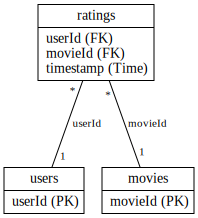

In [ ]:
graph = Graph(
	# These are the tables that participate in the graph: the keys of this
	# dictionary are the names of the tables, and the values are the Table
	# objects that correspond to these names:
	tables={
    'users' : users,
    'movies' : movies,
    'ratings' : ratings
	},

 	# These are the edges that define the primary key / foreign key
	# relationships between the tables defined above. Here, `src_table`
	# is the table that has the foreign key `fkey`, which maps to the
	# table `dst_table`'s primary key:`
	edges=[
    Edge(src_table='ratings', dst_table='users', fkey='userId'),
    Edge(src_table='ratings', dst_table='movies', fkey='movieId'),
	],
)

graph.visualize(show_cols=False)

## Writing a Predictive Query

After we've connected our data as Kumo Tables in a Kumo Graph, we can write a predictive query representing a business problem we would like to solve on our specified tables; please see the Kumo documentation for the specification of the predictive query language.

<img src="https://kumo-sdk-public.s3.us-west-2.amazonaws.com/kumo_pq.png" alt="drawing" width="700"/>


*See documentation [here](https://kumo-ai.github.io/kumo-sdk/docs/generated/kumoai.pquery.PredictiveQuery.html#kumoai.pquery.PredictiveQuery).*

### Aside: what to think about when thinking about PQs
When writing your predictive query, always focus on the underlying business problem you’re solving. In our case, we aim to build powerful personalization products, which require robust user and movie embeddings that we can easily search and compare.

There are two key considerations when building an embedding model with Kumo:
1.	**Pick supervision signal:** Supervision guides the embedding model by defining positive and negative interactions between users and movies. You can flexibly define what constitutes a positive event based on your business goals, directly influencing how the embedding space captures meaningful user-movie relationships.
  - Keep in mind that every positive (`user`, `movie`) interaction brings that pair closer in embedding space, and each negative interaction pushes them apart. After training we end up with both representations in the same embedding space.
2.	**Model Architecture:** Clearly specify your desired architecture when setting the `model_plan` parameters.

In [ ]:
# Construct a query to predict movies (movieId) the user is most likely to interact with
query = kumo.PredictiveQuery(
	graph=graph,
	query="PREDICT LIST_DISTINCT(ratings.movieId, 0, 14, days) RANK TOP 25 FOR EACH users.userId",
)

# Ensure this query is specified appropriately for this graph:
query.validate()

INFO:kumoai.pquery.predictive_query:Query PREDICT LIST_DISTINCT(ratings.movieId, 0, 14, days) RANK TOP 25 FOR EACH users.userId is configured correctly.


### Aside: On predictive queries...
Predictive queries are exactly what the name states, they are very much like *queries* which the reader might be familar with from SQL, but they are *predictive* i.e. the aggregations are *future* looking.  

Of course, since predictive queries are *future* looking we need to train a machine learning model to actually execute or rather answer the query. But once the model is trained the predictive query becomes *executable*, almost as if the underlying tables included records from the future. Of course, under the hood this just amounts to model inference, but if the model is trained well the exemplum above is very close to the truth.

#### Writing other queries
The Kumo abstraction is powerful precisely because there is no need to modify the underlying data in order to answer different *predictive queries* - the graph representation and our models make this possible. Here are some other queries you can define on the same graph we defined above.

A) **predicting user churn**
```
PREDICT COUNT(ratings.*, 0, 30, days) = 0
FOR EACH users.userId
```

B) **predicting user rating sum**
```
PREDICT SUM(ratings.rating, 0, 30, days)
FOR EACH users.userId
```

C) **forecast the count of users who will watch a particular movie**
```
PREDICT COUNT(ratings.userId, 0, 14, days)
FOR EACH movie.movieId
```


In [ ]:
# Fetch the machine learning task type for this query:
print(f"This query is a {query.get_task_type().replace('_', ' ')} task.")

This query is a temporal link prediction task.


## Training a Model

With a predictive query in place, we can now train a model to predict the desired outputs of the query over our Kumo Graph. The Kumo SDK supports modular execution of the different components of the training pipeline for ease of experimentation and hyperparameter tuning.

### Generating a Training Table

The first step of training is the generation of a training table from your predictive query. You can specify a granular plan to determine how exactly this is done, including specifications of elements like the `split`, `train_start_offset`, and more.

*See documentation [here](https://kumo-ai.github.io/kumo-sdk/docs/generated/kumoai.pquery.PredictiveQuery.html#kumoai.pquery.PredictiveQuery.generate_training_table).*

In [ ]:
# Launch an asynchronous (nonblocking) job to generate a training table, given
# our specified model plan.
train_table_job = query.generate_training_table(
    query.suggest_training_table_plan(),
    non_blocking=True)
# The ID of this job:
print(train_table_job.id)

gen-traintable-job-415cddd17de24b6092622dd2ef77f34b


### Training

After launching a training table generation job, we are ready to train a model. Following the same pattern as with training table generation, let's let Kumo intelligently suggest a model plan, that we can modify downstream:

<img src="https://kumo-sdk-public.s3.us-west-2.amazonaws.com/kumo_training.png" alt="drawing" width="700"/>

*See documentation [here](https://kumo-ai.github.io/kumo-sdk/docs/generated/kumoai.trainer.Trainer.html).*

In [ ]:
# Let Kumo intelligently suggest a modeling plan, given the
# specified graph and query:
model_plan = query.suggest_model_plan(run_mode=RunMode.FAST)

# Select `shallow-rhs` architecture
model_plan.model_architecture.module = 'embedding'

# We may want to limit a model to a single embedding output setting
# model_plan.model_architecture.output_embedding_dim = [64]

# Increase the number of 1st hop neighbors (user -> rating)
model_plan.neighbor_sampling.num_neighbors = [[64, 12]]

In [ ]:
# A Trainer object manages the execution of a training pipeline, according to
# the `model_plan` specification:
trainer = kumo.Trainer(model_plan)

# Launch an asynchronous (nonblocking) job to train a model, given
# our specified model plan. This job is scheduled and orchestrated by the
# Kumo platform, and is chained with the job to generate the training table
# launched above (it will sequence itself after training table generation is
# complete):
training_job = trainer.fit(
	graph=graph,
	train_table=train_table_job,
	non_blocking=True,
)

# The ID of this job:
print(f'The ID of our training job is {training_job.job_id}. To see the results later you can run kumo.TrainingJob("{training_job.job_id}").result()')

# Let's follow along...
training_job.attach()

The ID of our training job is trainingjob-8931b11ab4bc45529e61d9af7278a3fe. To see the results later you can run kumo.TrainingJob("trainingjob-8931b11ab4bc45529e61d9af7278a3fe").result()
Attaching to training job trainingjob-8931b11ab4bc45529e61d9af7278a3fe. To track this job in the Kumo UI, please visit https://demo-sdk.kumoai.cloud/jobs/training/trainingjob-8931b11ab4bc45529e61d9af7278a3fe. To detach from this job, please enter Ctrl+C: the job will continue to run, and you can re-attach anytime by calling the `attach()` method on the `TrainingJob` object. For example: kumoai.TrainingJob("trainingjob-8931b11ab4bc45529e61d9af7278a3fe").attach()
Waiting for job to start.
Current stage: Ingesting Data. In progress... Done.
Current stage: Waiting for Training Data to be generated. In progress... Done.
Current stage: Data Materialization. In progress... Done.
Current stage: Provisioning Resources. In progress... Done.
Current stage: Loading Materialized Data. In progress... Done.
Current s

Training:   0%|          |% done 

### Aside: Link prediction embedding models
Within the graph machine learning framework it's very easy to build a model which can embed two types of entities in the same embedding space by treating the problem as a link prediction task.

In essence, Kumo represents the relational data as a heterogeneous graph, and trains the model to predict which nodes will connect to other nodes in the future (or which connections are missing, if the graph is static in time).

There are three components to this:
- LHS entities/nodes = `user`
- RHS entities/nodes = `movie`
- Interaction = `user` rates a `movie`

This formulation is very flexible, if we had other interactions in the graph we could very well use those, for example watch events, likes, etc. Alternatively, we can identify other pairs of node types to produce embeddigns for, so long as we have a valuable signal of interaction between them.

#### Model architecture
Kumo provides several state-of-the art Graph Transformer architectures for link prediction [tasks](https://kumo.ai/docs/task-types#common-task-types). Namely, `two-tower`, `shallow-rhs` and `contextGNN` (link to [paper](https://arxiv.org/abs/2411.19513)) architectures. Each comes with their own advantages and disadvantages.

We will be using a `shallow-rhs` embedding architecture, which learns ID embeddings for each RHS entity (`movie`). The advantage is that we obtain highly expressive embeddings with little computational expense, but the drawback is that the model is `transductive`.


<img src="https://kumo-sdk-public.s3.us-west-2.amazonaws.com/shallow_rhs.png" alt="drawing" width="400"/>

## Generating Embeddings

After our training job is completed, we can generate batch embeddings using our trained model. We can choose to output these batch embeddings directly to a connector (e.g. Amazon S3, Databricks, Snowflake), or we can generate embeddings for download and export at our convenience later with the [`export`](https://kumo-ai.github.io/kumo-sdk/docs/generated/kumoai.trainer.BatchPredictionJobResult.html#kumoai.trainer.BatchPredictionJobResult.export) method.

We will do the latter here.

*See documentation [here](https://kumo-ai.github.io/kumo-sdk/docs/modules/trainer.html#batch-prediction).*

In [ ]:
# specify output connector
output_connector = kumo.S3Connector(root_dir='s3://kumo-public-datasets/movielens/embeddings/')

In [ ]:
# past finished training job
# training_job_id = 'trainingjob-7b62748768584fa9b5bf35016544d021'
# trainer = kumo.Trainer.load(training_job_id)
# query = kumo.PredictiveQuery.load_from_training_job(training_job_id)
# graph = query.graph

In [ ]:
embedding_job = trainer.predict(
  graph=graph,
  prediction_table=query.generate_prediction_table(non_blocking=True),
  training_job_id=training_job.job_id,  # use our training job's model
  non_blocking=True,
  output_config=OutputConfig(
    output_types={'embeddings'},
    output_connector=output_connector,
    output_table_name='user_movie_test1'
  )
)
embedding_job.attach()

Attaching to batch prediction job bp-job-6259fedd1916488385287525c7ee5af8. To track this job in the Kumo UI, please visit https://demo-sdk.kumoai.cloud/jobs/prediction/bp-job-6259fedd1916488385287525c7ee5af8. To detach from this job, please enter Ctrl+C (the job will continue to run, and you can re-attach anytime).
Waiting for job to start.
Current stage: Ingesting Data. In progress... Done.
Current stage: Waiting for Prediction Data to be generated. In progress... Done.
Current stage: Data Materialization. In progress... Done.
Current stage: Provisioning Resources. In progress... Done.
Current stage: Loading Materialized Data. In progress... Done.
Current stage: Predicting. In progress...

# Part 2: Using Kumo embeddings with Pinecone to personalize user experience

In this second part of the notebook we will focus on the steps that follow after you build your model in Kumo. Okay, so we have a model that can map both `users` and `movies` into the same embedding space. But what can we do with it?

Well, if our model does a good job this space represents a very useful tool, because users will be close in this space (as measured by our chosen `similarity_function`) to movies they are likely to interact with. By extension similar `users` will be close to each other and similar `movies` will be close to each other in this embedding space.

Above propery opens up a world of possibilities for us, we can use these three notions of similarity to build many personalization products:
- Recommend movies to users
- Find similar users
- Find similar movies
All by building a single model! Now only if we had a tool which makes it easy to query this space, i.e. given a user or movie can we find the embeddings closest to it. This is where Pinecone comes in, pinecone makes vector databases simple to understand!

## What's below
Below we will show some examples of storing and using existing embeddings (like our Kumo embedding!) in Pinecone. We will show examples of:
- Finding personalized movies for a user
- Finding similar movies
- An example of a hybrid search implementation, which allows us to personalize keyword search for each user!

## Install, Authenticate, and Initialize Pinecone
Now that we can go ahead and initialize the pinecone client.

In [ ]:
!pip install pinecone
!pip install pinecone_notebooks
# !pip install s3fs
# !pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.9/421.9 kB 9.0 MB/s eta 0:00:00


In [ ]:
import pinecone
from pinecone import Pinecone, ServerlessSpec

import pandas as pd
import numpy as np
from IPython.display import HTML, display

import os
import itertools

if not os.environ.get("PINECONE_API_KEY"):
    from pinecone_notebooks.colab import Authenticate
    Authenticate()

In [ ]:
# Initialize client
pc = Pinecone(api_key=os.environ.get("PINECONE_API_KEY"))

## Game plan
In order to implement the personalization solutions we mentioned earlier we will perform the following steps:
1. Load the `user` and `movie` embeddings
2. Join embeddings with the `movie` metadata
3. Create Pinecone index for both `users` and `movies`
4. Upsert data into indices
5. Demonstrate personalized movie recommendation
6. Demonstrate finding similar movies

## Prepare data
In the previous part of this notebook we used Kumo to generate the embeddings for both `users` and `movies` in the MovieLens dataset. We have exported the embeddings to S3.

We will now load the embeddings. NOTE: the embedding output has the following schema `['ID', 'TYPE', 'EMBEDDING']`, where `TYPE` is either `users` or `movies`. We will first separate the embeddings into separate dataframes. Because we are working with fairly small data we will do all our work locally.


First we load the data:

In [ ]:
import pandas as pd

In [ ]:
 # Read the output of the Kumo embedding job
embeddings = pd.read_parquet('s3://kumo-demo-datasets/movielens/embeddings/user_movie_embeddings.parquet/')
movies = pd.read_parquet('s3://kumo-demo-datasets/movielens/basic_with_posters/movies.parquet')
ratings = pd.read_parquet('s3://kumo-demo-datasets/movielens/basic_with_posters/ratings.parquet/')

Split the user and movie embeddings into separate dataframes:

In [ ]:
def get_user_and_movie_embeddings(df):
  """
  Given a dataframe with columns ['ID', 'TYPE', 'EMBEDDING'],
  return two dataframes: one for user embeddings (with ID renamed to 'userId')
  and one for movie embeddings (with ID renamed to 'movieId').
  """
  # Separate rows
  user_df = df[df['TYPE'] == 'users'].copy()
  movie_df = df[df['TYPE'] == 'movies'].copy()

  # Rename columns
  user_df.rename(columns={'ID': 'userId'}, inplace=True)
  movie_df.rename(columns={'ID': 'movieId'}, inplace=True)

  # Reset the index
  user_df.reset_index(drop=True, inplace=True)
  movie_df.reset_index(drop=True, inplace=True)

  return user_df[['userId', 'EMBEDDING']], movie_df[['movieId', 'EMBEDDING']]

user_embs, movie_embs = get_user_and_movie_embeddings(embeddings)

# randomly sample 1k users
user_embs = user_embs.sample(5000)

print("Number of user embeddings:", len(user_embs))
print("Number of movie embeddings:", len(movie_embs))

Number of user embeddings: 5000
Number of movie embeddings: 10269


In [ ]:
# merge movie embeddings with other metadata
movie_embs = pd.merge(
    movie_embs,
    movies[['title', 'genres', 'poster', 'movieId']],
    on="movieId",
    how="left"
)

In [ ]:
user_embs.head(5)

,userId,EMBEDDING
29281,126875,"[0.4089927, 0.15596591, -0.35514998, 0.6558638..."
26971,31070,"[0.08041377, 0.057336926, -0.4774758, 0.145147..."
25483,5393,"[0.31681156, 0.25866848, -0.5244701, 0.2225395..."
19370,6661,"[0.3729183, 0.10436365, -0.38383663, 0.5170867..."
36097,153855,"[0.28993806, -0.017835677, -0.67720664, 0.5017..."


In [ ]:
movie_embs.head(5)

,movieId,EMBEDDING,title,genres,poster
0,92196,"[-0.692878, -0.17644723, 0.18953605, -0.536136...",Crazy Horse (2011),Documentary,https://m.media-amazon.com/images/M/MV5BMjE5NG...
1,92374,"[-0.094674215, 0.57503706, 0.19659965, -0.8011...",Yolki 2 (2011),Comedy,https://m.media-amazon.com/images/M/MV5BMDg2MW...
2,92643,"[0.7598486, 1.0139743, 0.8244689, -1.1054865, ...",Monsieur Lazhar (2011),Children|Comedy|Drama,https://m.media-amazon.com/images/M/MV5BNjM0NT...
3,93552,"[-0.85924, -0.331058, 0.50398755, -0.081984386...",Blind (Beul-la-in-deu) (2011),Drama|Horror|Thriller,https://m.media-amazon.com/images/M/MV5BMTkzNz...
4,93752,"[-0.6153211, -0.20514478, 0.42778763, -0.26957...",Saving Face (2012),Documentary|Drama,https://m.media-amazon.com/images/M/MV5BNThkOG...


### Store `user` and `movie` embeddings in dense indices

A `pinecone` dense index stores dense vectors, which are numerical representations of the meaning and relationships of text, images, or other types of data. If you use an external embedding model (like Kumo) to convert your data to dense vectors, create a dense index as follows:

Since we've already produced embeddings of both `users` and `movies` we won't be using any [integrated embedding models](https://docs.pinecone.io/reference/api/2025-01/control-plane/create_for_model) that Pinecone provides. Instead we need to create a [dense index](https://docs.pinecone.io/reference/api/2025-01/control-plane/create_index) by providing doing the following:
- Provide a `name` for the index.
- Set the `vector_type` to `dense`.
- Specify the `dimension` and similarity `metric` of the vectors you’ll store in the index. This should match the dimension and metric supported by your embedding model.
- Set `spec.cloud` and `spec.region` to the cloud and region where the index should be deployed. Import the `ServerlessSpec` class, since we're working with Python.

Other parameters are optional. See the [API reference](https://docs.pinecone.io/reference/api/2025-01/control-plane/create_index) for details.

In [ ]:
# index names
movie_index_name = "movies-index"
user_index_name = "users-index"

embedding_dim = len(movie_embs['EMBEDDING'].iloc[0])

# Create movie index if it doesn't exist
if not pc.has_index(movie_index_name):
  pc.create_index(
    name=movie_index_name,
    dimension=embedding_dim,
    metric='dotproduct',
    spec=ServerlessSpec(
      cloud="aws",
      region="us-east-1"
    ),
  )

# Create user index if it doesn't exist
if not pc.has_index(user_index_name):
  pc.create_index(
    name=user_index_name,
    dimension=embedding_dim,
    metric='dotproduct',
    spec=ServerlessSpec(
      cloud="aws",
      region="us-east-1"
    ),
  )

# Now connect to these indices
movie_index = pc.Index(movie_index_name)
user_index = pc.Index(user_index_name)

### Upserting our data into the `user` index and `movie` index
We have created both the `user` and the `movie` index and we can proceed with upserting the embeddings into each index. An `Upsert` is the basic operation of adding (dense) data to Pinecone indices. Alternatively, we could also use `import` if we were dealing with very large data.

In order to upsert our own data into a dense index, we need to:

- Specify the `namespace` to upsert into. If the namespace doesn’t exist, it is created. To use the default namespace, set the namespace to an empty string (`""`).
- Format your input data as records, each with the following:
  - An `id` field with a unique record identifier for the index namespace.
  - A `values` field with the dense vector values.
  - Optionally, a `metadata` field with key-value pairs to store additional information or context. This alows for Metadata Filtering.

In [ ]:
# transform movie_embs to pinecone friendly format
movie_embs_pc = pd.DataFrame({
    'id': movie_embs['movieId'],
    'values': movie_embs['EMBEDDING'],
    'metadata': movie_embs[['title', 'genres', 'poster', 'movieId']].to_dict(orient='records')
})

# transform user_embs to pinecone friendly format
user_embs_pc = pd.DataFrame({
    'id': user_embs['userId'],
    'values': user_embs['EMBEDDING']
})

In [ ]:
# upsert movies
movie_index.upsert_from_dataframe(
    df=movie_embs_pc,
)

sending upsert requests:   0%|          | 0/10269 [00:00<?, ?it/s]

{'upserted_count': 10269}

In [ ]:
# upsert users
user_index.upsert_from_dataframe(
    df=user_embs_pc,
)

sending upsert requests:   0%|          | 0/5000 [00:00<?, ?it/s]

{'upserted_count': 5000}

We can perform a quick sanity check to see if the data has been upserted by fetching a movie entry:

In [ ]:
movie_index.fetch(ids=["92196"], namespace="")

FetchResponse(namespace='', vectors={'92196': Vector(id='92196', values=[-0.692878, -0.176447228, 0.18953605, -0.536136508, -0.249925777, -0.560492575, -0.0347835496, 0.0663761422, 0.246170118, -0.397063106, 0.137878582, 0.452405483, 0.329483032, -0.295125395, -0.267708063, 0.11085692, 0.235440329, 0.0689748898, 0.330064863, -0.245473638, 0.255116254, -0.103964798, 0.0833421797, 0.353449434, -0.38890925, 0.299163342, -0.0375199243, 0.360139638, 0.28604418, -0.470369279, 0.586901, 0.172865361, -0.174468979, -0.0898205265, -0.172712594, -0.395742, 0.359849483, 0.124656901, 0.145688295, 0.0534218736, 0.00882671215, 0.131214038, 0.0584079698, 0.145428941, -0.468755722, -0.204533279, -0.0454566777, -0.335710615, 0.947899878, 0.267457813, 0.560013413, -0.461288, 0.458088249, 0.0351200923, 0.159144238, 0.0651222914, 0.0709731132, 0.0506714284, 0.232988834, -0.162132233, 0.327170819, -0.00265975366, 0.116343915, 0.16967009], metadata={'genres': 'Documentary', 'movieId': '92196', 'poster': 'htt

## Exploring personalized user recommendations
To find recommended movies for a particular user we need to:
1. Get the `user` embedding via their `userId` from the `users` index
2. Use the `user` embedding from 1. to query the `movies` index
This will yield movies that are the closest to the user in embedding space, and thus most likely for the user to interact with next.


The helper function below fetches a user’s most recently rated movies and then queries Pinecone to find top recommended titles for that user. It displays the user’s rating history with posters and ratings, followed by a row of recommended movies showing their posters and similarity scores. It provides a quick way to visualize both the user’s past interactions and personalized recommendations side by side.

To learn more look at:
- [`index.fetch`](https://docs.pinecone.io/reference/api/2025-01/data-plane/fetch)
- [`index.query`](https://docs.pinecone.io/guides/data/query-data#semantic-search)


### HTML Helper function

In [ ]:
def display_user_history_and_recommendations(
    user_id,
    ratings_df,
    movie_df,
    user_index,
    movie_index,
    top_k=5,
    max_history=12
):
    """
    1) Display the user's most recent ratings (up to `max_history`).
    2) Display top-K recommended movies for that user in a row below.

    Assumes Pinecone's movie index has metadata:
      {
        'title': <str>,
        'poster': <str>,
        'genres': <str>
      }
    """
    # Filter the user's ratings
    user_ratings = ratings_df[ratings_df['userId'] == user_id].copy()
    # Sort by timestamp descending (most recent first)
    user_ratings.sort_values('timestamp', ascending=False, inplace=True)
    # Take up to `max_history` rows
    user_ratings = user_ratings.head(max_history)

    # Merge with movie metadata so we can show titles/posters
    user_ratings = user_ratings.merge(
        movie_df[['movieId', 'title', 'poster', 'genres']],
        on='movieId',
        how='left'
    )

    # Build HTML for displaying recent ratings
    html_str = "<h4>Recent Ratings</h4><div style='display:flex;flex-wrap:wrap;'>"
    for _, row in user_ratings.iterrows():
        title = row.get('title', 'Unknown Title')
        poster_url = row.get('poster', '')
        rating_val = row.get('rating', 'N/A')

        html_str += f"""
        <div style='margin:10px;text-align:center;'>
            <img src="{poster_url}" alt="{title}" width="120" style='display:block;margin-bottom:5px;'/>
            <div>{title}</div>
            <div>Rating: {rating_val}</div>
        </div>
        """
    html_str += "</div>"

    # Fetch user vector from Pinecone (index holding user embeddings)
    fetch_result = user_index.fetch(ids=[user_id])
    if fetch_result and fetch_result.vectors:
        user_vector = fetch_result.vectors[user_id].values

        # Query the movie index
        query_response = movie_index.query(
            vector=user_vector,
            top_k=top_k,
            include_metadata=True
        )

        # Build HTML for displaying recommended movies
        html_str += "<h4>Recommended Movies</h4><div style='display:flex;flex-wrap:wrap;'>"
        for match in query_response.matches:
            md = match.metadata or {}
            rec_title = md.get('title', 'Unknown Title')
            rec_poster = md.get('poster', '')
            rec_genres = md.get('genres', '')
            rec_score = match.score

            html_str += f"""
            <div style='margin:10px;text-align:center;'>
                <img src="{rec_poster}" alt="{rec_title}" width="120" style='display:block;margin-bottom:5px;'/>
                <div>{rec_title}</div>
                <div>Score: {rec_score:.4f}</div>
            </div>
            """
        html_str += "</div>"
    else:
        # If the user isn't found in the user index, no recommendations
        html_str += "<p>No user vector found, cannot generate recommendations.</p>"

    # Display everything
    display(HTML(html_str))

### Playground

In [ ]:
user_embs[['userId']].sample(5)

,userId
36649,145350
32982,120312
42302,154886
12977,94440
40782,145409


We can use our function to explore recommendations for a particular user, given their movie rating history! Feel free to explore different `query_user_id`'s.

In [ ]:
# For demonstration, pick a user ID that exists in your user index and ratings table
query_user_id = "108263"

display_user_history_and_recommendations(
    user_id=query_user_id,
    ratings_df=ratings,
    movie_df=movies,
    user_index=user_index,
    movie_index=movie_index,
    top_k=10,
    max_history=10
)

## Finding similar movies
We can repeat a similar excercise for finding similar movies. Except we now:
1. Get the `movie` embedding via their `movieId` from the `movie` index
2. Use the `movie` embedding from 1. to query the `movies` index
This will yield movies that are the closest to the query movie in embedding space, and are most likely to be interacted with by simliar users.

The helper function takes a given “anchor” movie, retrieves its embedding from Pinecone, and queries for similar movie embeddings. It displays the anchor movie’s details (title, poster, genres) followed by the top-K similar movies with their posters, genres, and similarity scores. It’s a handy way to visualize content-based recommendations or “more like this” experiences within a notebook.

#### HTML Helper

In [ ]:
def display_movie_and_similar(
    movie_id,
    movie_df,
    movie_index,
    top_k=5
):
    """
    1) Display the anchor movie's details (poster, title, genres).
    2) Display top-K similar movies by querying the same movie_index.

    Assumes:
    - movie_df has columns [movieId, title, poster, genres] (adjust as needed).
    - movie_index is a Pinecone index with embeddings for each movie.
    - The Pinecone metadata is stored as:
        {
          'title': <str>,
          'poster': <str>,
          'genres': <str>
        }
    """
    # Retrieve anchor movie info from local DataFrame
    # (Alternatively, you could fetch from Pinecone if you store full metadata there.)
    anchor_movie = movie_df[movie_df['movieId'] == movie_id].head(1)

    # Build HTML for the anchor movie
    html_str = "<h4>Anchor Movie</h4>"
    if len(anchor_movie) == 0:
        # If not found in local DF, just display a warning
        html_str += f"<p>Movie {movie_id} not found in local metadata.</p>"
    else:
        row = anchor_movie.iloc[0]
        title = row.get('title', 'Unknown Title')
        poster_url = row.get('poster', '')
        genres = row.get('genres', '')
        html_str += f"""
        <div style='margin-bottom:15px;'>
            <img src="{poster_url}" alt="{title}" width="120" style='display:block;margin-bottom:5px;'/>
            <div><strong>{title}</strong></div>
            <div>Genres: {genres}</div>
            <div>Movie ID: {movie_id}</div>
        </div>
        """

    # Fetch this movie's vector from Pinecone
    fetch_result = movie_index.fetch(ids=[movie_id])
    if not fetch_result or not fetch_result.vectors:
        html_str += f"<p>No vector found in Pinecone for movieId '{movie_id}'.</p>"
        display(HTML(html_str))
        return

    movie_vector = fetch_result.vectors[movie_id].values

    # Query for similar movies (include_metadata=True so we can read title, poster, etc.)
    query_response = movie_index.query(
        vector=movie_vector,
        top_k=top_k,
        include_metadata=True
    )

    # Build HTML for similar movies
    html_str += "<h4>Similar Movies</h4><div style='display:flex;flex-wrap:wrap;'>"
    for match in query_response.matches:
        md = match.metadata or {}
        similar_title = md.get('title', 'Unknown Title')
        similar_poster = md.get('poster', '')
        similar_genres = md.get('genres', '')
        score = match.score

        html_str += f"""
        <div style='margin:10px;text-align:center;'>
            <img src="{similar_poster}" alt="{similar_title}" width="120" style='display:block;margin-bottom:5px;'/>
            <div>{similar_title}</div>
            <div>Score: {score:.4f}</div>
        </div>
        """
    html_str += "</div>"

    # Display everything
    display(HTML(html_str))

### Playground

In [ ]:
movie_embs.sample(10)

,movieId,EMBEDDING,title,genres,poster
5112,166245,"[0.7574303, -0.12714083, 0.039902356, 0.949986...",Good Kids (2016),Comedy,https://m.media-amazon.com/images/M/MV5BMTc1Nj...
4615,162768,"[-0.077845, -0.34369758, 0.2664674, 0.29583338...",Out of Love (2016),Drama,https://m.media-amazon.com/images/M/MV5BNTBiNz...
4561,162540,"[0.030866267, 0.3192884, -0.015940899, 0.45453...",Amateur Night (2016),Comedy,https://m.media-amazon.com/images/M/MV5BZTQ2N2...
4682,163468,"[-0.44087893, -0.08144211, 0.58524895, -0.2222...",Maz Jobrani: I'm Not a Terrorist But I've Play...,Comedy,https://m.media-amazon.com/images/M/MV5BZTRhMG...
5052,165841,"[-0.17871223, -0.14920716, 0.17397414, 0.37675...",All These Sleepless Nights (2016),Documentary,https://m.media-amazon.com/images/M/MV5BMjA0ND...
8952,194947,"[-0.023676129, 0.1615332, 0.39900583, -0.20030...",Cam (2018),Horror|Thriller,https://m.media-amazon.com/images/M/MV5BYWYwZD...
7863,186903,"[-0.40621254, -0.5325371, 0.08453919, 0.165804...",Greg Davies: You Magnificent Beast (2018),Comedy,https://m.media-amazon.com/images/M/MV5BMWI1Yz...
689,112735,"[-0.14697719, -0.09704951, -0.10601158, -0.080...",Charlie's Country (2013),Drama,https://m.media-amazon.com/images/M/MV5BMTQ4OT...
7538,184453,"[-0.1685566, 0.024316644, 0.31974322, -0.11731...",He's Way More Famous Than You (2013),Comedy,https://m.media-amazon.com/images/M/MV5BMTkyMz...
7976,187655,"[-0.060699537, -0.14766778, 0.022586348, -0.09...",Genesis: The Fall of Eden (2018),Sci-Fi,https://m.media-amazon.com/images/M/MV5BZTczNG...


In [ ]:
# Suppose we have a movieId
anchor_movie_id = "140096"

display_movie_and_similar(
    movie_id=anchor_movie_id,
    movie_df=movie_embs,
    movie_index=movie_index,
    top_k=10
)

## Hybrid Search: Personalizing user's keyword search
But we can go beyond just querying with dense vectors or performing keyword search. Pinecone allows for simple implementations of **hybrid search** which combines both to get the best of both worlds. Here we will show just a single implementation, but if you want to learn more please take a look at the Pinecone documentation on the topic: [Getting Started with Hybrid Search](https://www.pinecone.io/learn/hybrid-search-intro/).

 The premise is quite straightforward, let's say we are building a streaming service and we would like to provide our users with a search bar to find the next movie to watch. Most user queries will be very simple (e.g. "Action adventure") and a simple keyword search can be improved upon as all action adventure movies stil need to be ranked. It turns out we can do this in a personalized way, by combining keyword search with dense similarity between `users` and `movies`.

 Below is a demonstration of combining:
 - **Kumo embeddings**: which bring a notion of user<>movie similarity, and
 - **Keyword search**: which guides the recommendations towards a particular user query

In addition to the dense vector movie index we have already created and used we now need to create a separate sparse index. We will query both indices and combine their recommendations to construct the final ranking for `user` + `text_query`.

### Create an integrated sparse movie index

In [ ]:
# prepare sparse index
sparse_index_name = "sparse-movie-index"

if not pc.has_index(sparse_index_name):
  pc.create_index_for_model(
    name=sparse_index_name,
    embed={
        "model" : "pinecone-sparse-english-v0",
        "field_map" : {
            "text" : "description",
        },
    },
    cloud="aws",
    region="us-east-1"
  )

# Now connect to it
sparse_index = pc.Index(sparse_index_name)

We did something differntly than before, well two things actually:
1. We are working with a [`sparse_index`](https://docs.pinecone.io/guides/indexes/understanding-indexes). Such indecis allow us to perform **lexical** or **keyword search**
2. We won't be embedding the text ourselves, we will rely on `Pinecone` to do this with us. This is why we used `pc.create_index_for_model()`, we already specified that `pinecone-sparse-english-v0` is the model used for embedding the inputs into this index.


Let's take an example encoding:

In [ ]:
pc.inference.embed(
    model="pinecone-sparse-english-v0",
    inputs=["The Toy Story franchise, starting with the 1995 film, follows the adventures of a group of toys who come to life when their owner, Andy, isn't around, with the story exploring themes of friendship, loyalty, and the changing roles of toys in a child's life"],
    parameters={
    "input_type": "passage", # or query
    "return_tokens": True,
    }
)

EmbeddingsList(
  model='pinecone-sparse-english-v0',
  vector_type='sparse',
  data=[
    {'vector_type': sparse, 'sparse_values': [0.2849121, 0.34326172, ..., 1.9628906, 0.36767578], 'sparse_indices': [131900689, 152217691, ..., 4254144768, 4283091697], 'sparse_tokens': ['in', 'to', ..., 'follows', 's']}
  ],
  usage={'total_tokens': 58}
)

### Batch upsert `text` into sparse movie index
Let's upsert our movies into the index.

In [ ]:
# transform movies into Pinecone sparse friendly form
movie_embs_pc_sparse = pd.DataFrame({
    'id': movie_embs['movieId'],
    'description': movie_embs['title'] + ": " + movie_embs['genres'].apply(lambda s: " ".join(s.split("|")),),  #+ " ".join(movie_embs['genres'].split("|")),
})

In [ ]:
# batching function
def chunks(iterable, batch_size=32):
    """Break iterable into chunks of size batch_size."""
    it = iter(iterable)
    chunk = tuple(itertools.islice(it, batch_size))
    while chunk:
        yield chunk
        chunk = tuple(itertools.islice(it, batch_size))

# data generator for batching
def data_generator(df):
    for _, row in df.iterrows():
        yield (row['id'], row['description'])

In [ ]:
# iterate over batches and upsert into the sparse index
for chunk_batch in chunks(data_generator(movie_embs_pc_sparse), batch_size=32):
    text_to_upsert = [
        {
            'id': vec_id,
            'description': desc,
        }
        for vec_id, desc in chunk_batch
    ]
    sparse_index.upsert_records(
        namespace="",
        records=text_to_upsert
    )

We have successfully upserted the movie data into the sparse index. We can now use this index to perform hybrid search over both text and user similarity. Moreover, we didn't have to actually embedd anything ourselves, we used `pinecone-sparse-english-v0` hosted by Pinecone to do it instead!

### Perform Hybrid search
We now have everything we need to develop our hybrid search application. For valuable references see:
- [Query a sparse-dense index with explicit weighting](https://docs.pinecone.io/guides/indexes/pods/query-sparse-dense-vectors#query-a-sparse-dense-index-with-explicit-weighting)
- [Introducing cascading retrieval: Unifying dense and sparse with reranking](https://www.pinecone.io/blog/cascading-retrieval/)

In short we will, given the input of `userId` and `text_query`:
1. retrieve many `movie` candidates with the `text_query` (using `pinecone-sparse-english-v0`)
2. fetch the `user` embedding from the `users` index
3. query the `movie` index and filter by metadata to get scores for all the retrieved `movieId`s
4. re-rank with a simple re-ranking function based on both `sparse` and `dense` score

In [ ]:
import numpy as np

def rerank_candidates_with_dense(
    sparse_candidates,
    user_vector,
    dense_movie_index,
    alpha=0.5,
    sort_score='hybrid_score'  # can be 'sparse_score' or 'dense_score'
):
    """
    1) Extract the list of movie IDs from sparse_candidates.
    2) Query those items from 'dense_movie_index' using a filter.
    3) Use the returned '.score' from Pinecone as 'dense_score'.
    4) Return a new sorted list of dicts:
        {
          'movieId': ...,
          'sparse_score': ...,
          'dense_score': ...,
          'hybrid_score': ...,
          'metadata': ...
        }
       sorted descending by 'hybrid_score'. Where:
       - 'hybrid_score' = alpha * 'sparse_score' + (1 - alpha) * 'dense_score'
    """

    if not user_vector:
        return []

    # 1) Gather movie IDs
    movie_ids = [r['_id'] for r in sparse_candidates]

    # 2) Filtered query to Pinecone.
    query_res = dense_movie_index.query(
        vector=user_vector,
        filter={"movieId": {"$in": movie_ids}},
        top_k=len(movie_ids),
        include_values=False,
        include_metadata=True
    )

    # Build a lookup {id: match_object}
    dense_matches = {}
    if query_res and query_res.matches:
        dense_matches = {m.id: m for m in query_res.matches}

    # 3) Combine sparse_score + dense_score
    results = []
    for item in sparse_candidates:
        rid = str(item['_id'])
        sparse_score = item.get('_score', 0.0)
        match_data = dense_matches[rid]
        dense_score = match_data.score

        # Weighted hybrid score
        hybrid_score = alpha * sparse_score + (1 - alpha) * dense_score

        results.append({
            'movieId': rid,
            'sparse_score': sparse_score,
            'dense_score': dense_score,
            'hybrid_score': hybrid_score,
            'metadata': match_data.metadata or {}
        })

    # 4) Sort descending by 'sort_score'
    results.sort(key=lambda x: x[sort_score], reverse=True)
    return results


def retrieve_and_rerank(
    user_id,
    text_query,
    user_index,
    sparse_index,
    dense_index,
    top_k_sparse=20,
    top_k_final=10,
    alpha=0.5
):
    # 1) Sparse retrieval
    sparse_candidates = sparse_index.search_records(
        namespace="",
        query={
            "inputs": {"text": text_query},
            "top_k": top_k_sparse,
        },
        fields=["description"]
    ).result.hits
    if not sparse_candidates:
        print("No sparse candidates found.")
        return []

    # 2) Get user's dense embedding
    user_vec = user_index.fetch(ids=[user_id]).vectors[user_id].values
    if user_vec is None:
        print(f"No embedding found for user '{user_id}'. Cannot re-rank.")
        return sparse_candidates  # or return []

    # 3) Re-rank by using Pinecone's internal similarity score
    final_results = rerank_candidates_with_dense(
        sparse_candidates,
        user_vec,
        dense_index,
        alpha=alpha
    )

    return final_results[:top_k_final]

Function to putting it all together:

In [ ]:
def display_hybrid_results(matches, heading="Hybrid Search Results", sort_score='hybrid_score'):
    html_str = f"<h4>{heading}</h4><div style='display:flex;flex-wrap:wrap;'>"
    if not matches:
        html_str += "<p>No results found.</p>"
    else:
        for match in matches:
            md = match.get('metadata') or {}
            title = md.get('title', 'Unknown Title')
            poster_url = md.get('poster', '')
            genres = md.get('genres', '')
            score_val = match.get(sort_score)

            html_str += f"""
            <div style='margin:10px;text-align:center;'>
                <img src="{poster_url}" alt="{title}" width="120" style='display:block;margin-bottom:5px;'/>
                <div>{title}</div>
                <div>Genres: {genres}</div>
                <div>Score: {score_val:.4f}</div>
            </div>
            """
    html_str += "</div>"
    display(HTML(html_str))

And it's as easy as that, feel free to play with the `user` anchor and the `text_query` below.

In [ ]:
user_embs.sample(5)

,userId,EMBEDDING
4383,56180,"[0.44935083, 0.18861422, -0.40817547, 0.574801..."
26134,5839,"[0.16136876, 0.056439295, -0.49999896, 0.16478..."
8658,47698,"[-0.011269495, 0.0056284517, -0.46137083, 0.01..."
16262,73940,"[0.33393583, 0.2415386, -0.51072073, 0.3245950..."
9023,83399,"[0.35129237, 0.25972885, -0.36625588, 0.224390..."


In [ ]:
user_id_example = "83973"
text_query = "Sci-fi"

final_recs = retrieve_and_rerank(
    user_id=user_id_example,
    text_query=text_query,
    user_index=user_index,
    sparse_index=sparse_index,
    dense_index=movie_index,
    top_k_sparse=100,
    top_k_final=15,
    alpha=0.7,
)

display_hybrid_results(
    final_recs,
    heading=f"Cascading/Hybrid Search for '{text_query}'",)

# Conclusion
In this notebook example we went on a journey of building our own `user` and `movie` embeddings with Kumo and building out actual personalization solutions in Pinecone.

The recipes given in this notebook are meant to be very general so we are looking forward to seeing both Kumo and Pinecone applied in may exciting applications.

For any questions feel free to consult both Kumo or Pinecone docs:
- [Kumo docs](https://kumo.ai/docs/overview)
- [Pinecone docs](https://docs.pinecone.io/guides/get-started/overview)